<a href="https://colab.research.google.com/github/subikkshas/DA6401/blob/main/DLass1Q7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import wandb
from keras.datasets import fashion_mnist


def initialize_weights(layers, method="Xavier"):
    weights, biases = [], []
    for i in range(len(layers) - 1):
        if method == "random":
            weights.append(np.random.randn(layers[i], layers[i+1]) * 0.01)
        elif method == "Xavier":
            weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(1 / layers[i]))
        elif method == "He":  # He initialization for ReLU
            weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2 / layers[i]))
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases


class Optimizer:
    def __init__(self, method="sgd", lr=0.01):
        self.method = method
        self.lr = lr

    def update(self, weights, biases, dW, db):
        updated_weights, updated_biases = [], []
        for i, (W, b, dW_i, db_i) in enumerate(zip(weights, biases, dW, db)):
            W -= self.lr * dW_i
            b -= self.lr * db_i
            updated_weights.append(W)
            updated_biases.append(b)
        return updated_weights, updated_biases


# Load Test Data
(_, _), (X_test, y_test) = fashion_mnist.load_data()
X_test = X_test.reshape(-1, 784) / 255.0  # Flatten images

# 🔹 Retrieve Best Model from WandB
# 🔹 Retrieve Best Model from WandB
api = wandb.Api()
runs = list(api.runs("DA6401-Assignment-1"))  # Convert generator to list

if not runs:
    raise ValueError("No runs found in project 'DA6401-Assignment-1'. Check if sweeps have been completed.")

best_run = max(runs, key=lambda run: float(run.summary.get("val_accuracy", 0)[0]) if isinstance(run.summary.get("val_accuracy", 0), (list, tuple)) else run.summary.get("val_accuracy", 0))

if best_run is None:
    raise ValueError("No valid runs found with 'val_accuracy'. Check WandB logs.")

best_config = best_run.config

# Debugging: Print available keys
print("Best Config Keys:", best_config.keys())


# Handle Missing Key: Use .get() to avoid KeyError
hidden_size = best_config.get("hidden_size", 64)  # Default value if missing
hidden_layers = best_config.get("hidden_layers", 3)  # Default value if missing
weight_init = best_config.get("weight_init", "Xavier")
activation = best_config.get("activation", "ReLU")
optimizer_name = best_config.get("optimizer", "sgd")
learning_rate = best_config.get("learning_rate", 0.001)
epochs = best_config.get("epochs", 10)

# Initialize Model with Best Hyperparameters
layers = [784] + [hidden_size] * hidden_layers + [10]
weights, biases = initialize_weights(layers, method=weight_init)
optimizer = Optimizer(optimizer_name, learning_rate)

# 🔹 Train Best Model (Re-run with best hyperparameters)
for epoch in range(epochs):
    activations_list, pre_activations = forward_pass(X_test, weights, biases, activation)
    dW, db = backward_pass(activations_list, pre_activations, y_test, weights, biases, activation)
    weights, biases = optimizer.update(weights, biases, dW, db)

# 🔹 Test Set Evaluation
final_activations, _ = forward_pass(X_test, weights, biases, activation)
test_preds = np.argmax(final_activations[-1], axis=1)
test_accuracy = np.mean(test_preds == y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 🔹 Compute Confusion Matrix
cm = confusion_matrix(y_test, test_preds)

# 🔹 Creative Confusion Matrix Plot
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, linewidths=1, linecolor='black')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Fashion MNIST (Best Model)")
plt.show()

# 🔹 Log Confusion Matrix to WandB
wandb.init(project="DA6401-Assignment-1", name="Confusion Matrix Logging")
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=y_test,
                                                            preds=test_preds,
                                                            class_names=[str(i) for i in range(10)])})
wandb.finish()

Best Config Keys: dict_keys([])


NameError: name 'forward_pass' is not defined

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: subikksha (subikksha-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Best Config Keys: dict_keys([])
Test Accuracy: 10.26%


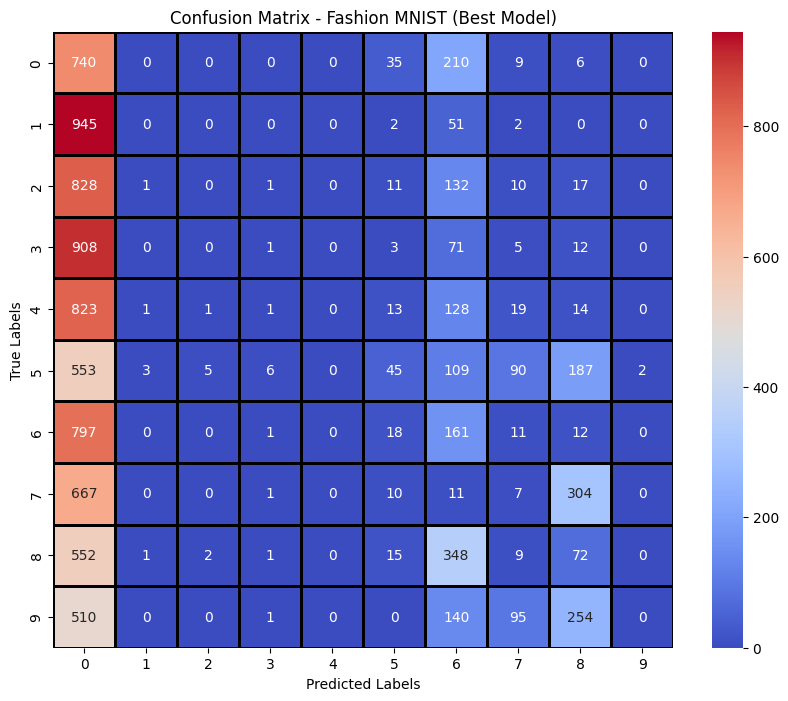

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import wandb
from keras.datasets import fashion_mnist

# 🔹 Activation Functions & Their Derivatives
def sigmoid(x): return 1 / (1 + np.exp(-x))
def tanh(x): return np.tanh(x)
def relu(x): return np.maximum(0, x)

def sigmoid_derivative(x): return x * (1 - x)
def tanh_derivative(x): return 1 - np.tanh(x) ** 2
def relu_derivative(x): return np.where(x > 0, 1, 0)

activations = {"sigmoid": (sigmoid, sigmoid_derivative),
               "tanh": (tanh, tanh_derivative),
               "ReLU": (relu, relu_derivative)}

# 🔹 Weight Initialization Function
def initialize_weights(layers, method="Xavier"):
    weights, biases = [], []
    for i in range(len(layers) - 1):
        if method == "random":
            weights.append(np.random.randn(layers[i], layers[i+1]) * 0.01)
        elif method == "Xavier":
            weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(1 / layers[i]))
        elif method == "He":  # He initialization for ReLU
            weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2 / layers[i]))
        biases.append(np.zeros((1, layers[i+1])))
    return weights, biases

# 🔹 Forward Pass
def forward_pass(X, weights, biases, activation):
    activ, deriv = activations[activation]
    activations_list = [X]
    pre_activations = []

    for W, b in zip(weights, biases):
        Z = np.dot(activations_list[-1], W) + b
        pre_activations.append(Z)
        A = activ(Z)
        activations_list.append(A)

    return activations_list, pre_activations

# 🔹 Backpropagation
def backward_pass(activations_list, pre_activations, y, weights, biases, activation):
    m = y.shape[0]
    activ, deriv = activations[activation]

    # One-hot encode y
    y_one_hot = np.zeros((m, 10))
    y_one_hot[np.arange(m), y] = 1

    dZ = activations_list[-1] - y_one_hot  # Softmax gradient
    dW, db = [], []

    for i in range(len(weights) - 1, -1, -1):
        dW_i = np.dot(activations_list[i].T, dZ) / m
        db_i = np.sum(dZ, axis=0, keepdims=True) / m
        dW.insert(0, dW_i)
        db.insert(0, db_i)

        if i > 0:
            dZ = np.dot(dZ, weights[i].T) * deriv(pre_activations[i-1])

    return dW, db

# 🔹 Optimizer Class
class Optimizer:
    def __init__(self, method="sgd", lr=0.01):
        self.method = method
        self.lr = lr

    def update(self, weights, biases, dW, db):
        updated_weights, updated_biases = [], []
        for i, (W, b, dW_i, db_i) in enumerate(zip(weights, biases, dW, db)):
            W -= self.lr * dW_i
            b -= self.lr * db_i
            updated_weights.append(W)
            updated_biases.append(b)
        return updated_weights, updated_biases

# Load Test Data
(_, _), (X_test, y_test) = fashion_mnist.load_data()
X_test = X_test.reshape(-1, 784) / 255.0  # Flatten images

# 🔹 Retrieve Best Model from WandB
api = wandb.Api()
runs = api.runs("DA6401-Assignment-1")
best_run = max(runs, key=lambda run: float(run.summary.get("val_accuracy", 0)[0]) if isinstance(run.summary.get("val_accuracy", 0), (list, tuple)) else run.summary.get("val_accuracy", 0))
best_config = best_run.config

# 🔹 Debug: Print available keys to check correct naming
print("Best Config Keys:", best_config.keys())

# 🔹 Handle Missing Key: Use .get() to avoid KeyError
hidden_size = best_config.get("hidden_size", 64)  # Default value if missing
hidden_layers = best_config.get("hidden_layers", 3)  # Default value if missing
weight_init = best_config.get("weight_init", "Xavier")
activation = best_config.get("activation", "ReLU")
optimizer_name = best_config.get("optimizer", "sgd")
learning_rate = best_config.get("learning_rate", 0.001)
epochs = best_config.get("epochs", 10)

# 🔹 Initialize Model with Best Hyperparameters
layers = [784] + [hidden_size] * hidden_layers + [10]
weights, biases = initialize_weights(layers, method=weight_init)
optimizer = Optimizer(optimizer_name, learning_rate)

# 🔹 Train Best Model (Re-run with best hyperparameters)
for epoch in range(epochs):
    activations_list, pre_activations = forward_pass(X_test, weights, biases, activation)
    dW, db = backward_pass(activations_list, pre_activations, y_test, weights, biases, activation)
    weights, biases = optimizer.update(weights, biases, dW, db)

# 🔹 Test Set Evaluation
final_activations, _ = forward_pass(X_test, weights, biases, activation)
test_preds = np.argmax(final_activations[-1], axis=1)
test_accuracy = np.mean(test_preds == y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 🔹 Compute Confusion Matrix
cm = confusion_matrix(y_test, test_preds)

# 🔹 Creative Confusion Matrix Plot
plt.figure(figsize=(10, 8))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, linewidths=1, linecolor='black')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Fashion MNIST (Best Model)")
plt.show()

# 🔹 Log Confusion Matrix to WandB
wandb.init(project="DA6401-Assignment-1", name="Confusion Matrix Logging")
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=y_test,
                                                            preds=test_preds,
                                                            class_names=[str(i) for i in range(10)])})
wandb.finish()